# Предсказание ухода абонента для телеком компании

## **Информация**

### **Описание задачи**

Оператор связи хочет бороться с оттоком клиентов. Для этого его сотрудники начнут предлагать промокоды и специальные условия всем, кто планирует отказаться от услуг связи. Чтобы заранее находить таких пользователей, компании нужна модель, которая будет предсказывать, разорвёт ли абонент договор. Команда оператора собрала персональные данные о некоторых клиентах, информацию об их тарифах и услугах. Задача — обучить на этих данных модель для прогноза оттока клиентов.

### **Описание услуг**

Оператор предоставляет два основных типа услуг:

**Стационарную телефонную связь.** Телефон можно подключить к нескольким линиям одновременно.

**Интернет.** Подключение бывает двух типов: через телефонную линию DSL или оптоволоконный кабель.

Также абонентам доступен ряд интернет услуг:

**Интернет-безопасность:** антивирус (Device Protection) и блокировка опасных сайтов (Online Security);

**Выделенная линия технической поддержки** (Tech Support);

**Облачное хранилище файлов для резервного копирования данных** (Online Backup);

**Стриминговое телевидение** (Streaming TV) и каталог фильмов (Streaming Movies).

За услуги клиенты могут платить ежемесячно или раз в 1–2 года. Доступны различные способы расчёта и возможность получить электронный чек.


### **План проекта**

1. Изучение базы данных;
2. Выгрузка нужных для моделирования данных в pandas и их первичный осмотр;
3. Статистический анализ данных;
4. Предобработка данных;
5. Обучение модели;
6. Тестирование модели.

**Целевой показатель модели – ROC-AUC ≥ 0.85**

### **Описание данных**


Данные хранятся в базе данных.
Она состоит из нескольких таблиц:

`contract` — информация о договорах;

`personal` — персональные данные клиентов;

`internet` — информация об интернет-услугах;

`phone` — информация об услугах телефонии.

Таблица `contract`

`customerID` — ID абонента;

`BeginDate` — дата начала действия договора;

`EndDate` — дата окончания действия договора;

`Type` — тип оплаты: раз в год-два или ежемесячно;

`PaperlessBilling` — электронный расчётный лист;

`PaymentMethod` — тип платежа;

`MonthlyCharges` — расходы за месяц;

`TotalCharges` — общие расходы абонента.

Таблица `personal`

`customerID` — ID пользователя;

`gender` — пол;

`SeniorCitizen` — является ли абонент пенсионером;

`Partner` — есть ли у абонента супруг или супруга;

`Dependents` — есть ли у абонента дети.

Таблица `internet`

`customerID` — ID пользователя;

`InternetService` — тип подключения;

`OnlineSecurity` — блокировка опасных сайтов;

`OnlineBackup` — облачное хранилище файлов для резервного копирования данных;

`DeviceProtection` — антивирус;

`TechSupport` — выделенная линия технической поддержки;

`StreamingTV` — стриминговое телевидение;

`StreamingMovies` — каталог фильмов.

Таблица `phone`

`customerID` — ID пользователя;

`MultipleLines` — подключение телефона к нескольким линиям одновременно.

Информация о договорах актуальна на 1 февраля 2020.

### **ER диаграмма**

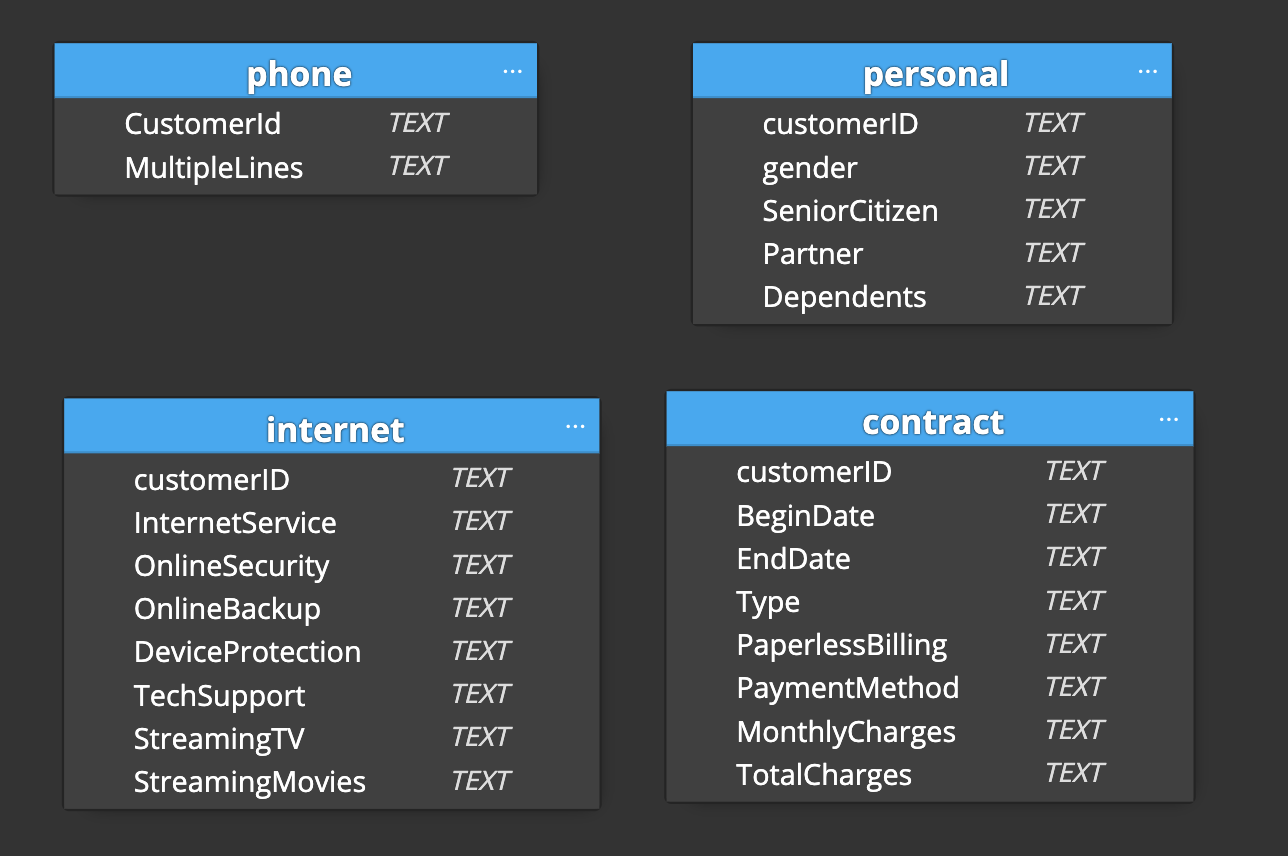

Все данные записаны как текст, что не совпадает с их природой и требует дальнейшей обработки

## Установка зависимостей и константы

In [1]:
!wget https://code.s3.yandex.net/data-scientist/ds-plus-final.db
!pip install -q catboost
!pip install -q optuna
!pip install -q phik
!pip install -q scikit-learn
!pip install -q imbalanced-learn

--2026-01-29 18:35:33--  https://code.s3.yandex.net/data-scientist/ds-plus-final.db
Resolving code.s3.yandex.net (code.s3.yandex.net)... 93.158.134.158, 2a02:6b8::2:158
Connecting to code.s3.yandex.net (code.s3.yandex.net)|93.158.134.158|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3588096 (3.4M) [application/octet-stream]
Saving to: ‘ds-plus-final.db’

ds-plus-final.db    100%[===================>]   3.42M  1.83MB/s    in 1.9s    

2026-01-29 18:35:37 (1.83 MB/s) - ‘ds-plus-final.db’ saved [3588096/3588096]

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 413.9/413.9 kB 24.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 679.7/679.7 kB 44.8 MB/s eta 0:00:00


In [2]:
import os
import optuna
import sklearn
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import tensorflow as tf
from sqlalchemy import create_engine, inspect
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.metrics import AUC
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import OrdinalEncoder, StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.utils.class_weight import compute_class_weight
from catboost import CatBoostClassifier
from phik import resources
from phik.report import plot_correlation_matrix

In [3]:
RS = 230225
sns.set_theme(style="whitegrid", palette="deep")

## Изучение базы данных

In [4]:
# Подключаемся к базе данных
path_to_db = 'ds-plus-final.db'
engine = create_engine(f'sqlite:///{path_to_db}', echo=False)

In [5]:
# Получаем список всех таблиц в базе данных
query = "SELECT name FROM sqlite_master WHERE type='table';"
tables = pd.read_sql(query, engine)

print("Список таблиц в базе данных:")
print(tables)

Список таблиц в базе данных:
              name
0         data_arc
1        data_bulk
2   data_bulk_time
3   data_wire_time
4         contract
5         personal
6            phone
7         internet
8         data_gas
9        data_temp
10       data_wire


В базе данных присутствуют все нужные таблицы, помимо них, в базе данных есть таблицы, не относящиеся к задаче. Создадим новую базу данных, в которой будут только нужные таблицы для удобства работы.

In [6]:
# Пути к исходной и новой базам данных
original_db = 'sqlite:///ds-plus-final.db'
new_db = 'sqlite:///new_database.db'

# Подключение к исходной и новой базам данных
engine_original = create_engine(original_db)
engine = create_engine(new_db)

# Список таблиц для копирования
tables_to_copy = ['contract',
                  'personal',
                  'phone',
                  'internet']

for table in tables_to_copy:
    # Читаем данные из исходной базы
    df = pd.read_sql_table(table, engine_original)

    # Сохраняем данные в новую базу
    df.to_sql(table, engine, if_exists='replace', index=False)
    print(f"Таблица {table} успешно скопирована.")

query = "SELECT name FROM sqlite_master WHERE type='table';"
tables = pd.read_sql(query, engine)

Таблица contract успешно скопирована.
Таблица personal успешно скопирована.
Таблица phone успешно скопирована.
Таблица internet успешно скопирована.


In [7]:
# Проверяем, содержит ли каждая таблица данные
table_data_info = {}
for table in tables['name']:
    df = pd.read_sql(f"SELECT * FROM {table} LIMIT 5;", engine)  # Просматриваем первые 5 строк
    count_query = pd.read_sql(f"SELECT COUNT(*) AS count FROM {table};", engine)
    table_data_info[table] = {
        'columns': list(df.columns),
        'rows': count_query['count'].iloc[0]
    }

# Выводим информацию о таблицах
for table, info in table_data_info.items():
    print(f"Таблица: {table}")
    print(f"  Количество строк: {info['rows']}")
    print(f"  Столбцы: {info['columns']}")
    print()

Таблица: contract
  Количество строк: 7043
  Столбцы: ['customerID', 'BeginDate', 'EndDate', 'Type', 'PaperlessBilling', 'PaymentMethod', 'MonthlyCharges', 'TotalCharges']

Таблица: personal
  Количество строк: 7043
  Столбцы: ['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents']

Таблица: phone
  Количество строк: 6361
  Столбцы: ['CustomerId', 'MultipleLines']

Таблица: internet
  Количество строк: 5517
  Столбцы: ['customerID', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies']



In [8]:
# Функция для анализа данных в таблице
def analyze_table(table_name):
    print(f"\nАнализ таблицы: {table_name}")

    # Загружаем данные
    df = pd.read_sql(f"SELECT * FROM {table_name};", engine)

    # Размер таблицы
    print(f"Размер таблицы: {df.shape[0]} строк, {df.shape[1]} столбцов")

    # Проверяем пропуски
    missing_data = df.isnull().sum()
    print("\nКоличество пропусков по каждому столбцу:")
    print(missing_data[missing_data > 0])

for table in tables['name']:
    analyze_table(table)


Анализ таблицы: contract
Размер таблицы: 7043 строк, 8 столбцов

Количество пропусков по каждому столбцу:
Series([], dtype: int64)

Анализ таблицы: personal
Размер таблицы: 7043 строк, 5 столбцов

Количество пропусков по каждому столбцу:
Series([], dtype: int64)

Анализ таблицы: phone
Размер таблицы: 6361 строк, 2 столбцов

Количество пропусков по каждому столбцу:
Series([], dtype: int64)

Анализ таблицы: internet
Размер таблицы: 5517 строк, 8 столбцов

Количество пропусков по каждому столбцу:
Series([], dtype: int64)


В изначальных таблицах нет Nan, однако длины таблиц различаются, что, вероятно, приведёт к пропускам при объединении таблиц.

## **Статистический анализ данных**

### **Функции**

In [9]:
def analyze_column(df: pd.DataFrame, column: str):
    """
    Анализирует столбец датафрейма в зависимости от его типа.

    Для числовых данных:
        - строит боксплот (boxplot)
        - строит гистограмму (histogram) с линиями среднего и медианы
    Для категориальных данных:
        - строит круговую диаграмму (pie chart)
    Для временных данных:
        - строит гистограмму распределения
        - строит график тренда (line plot)

    Параметры:
        df (pd.DataFrame): датафрейм для анализа
        column (str): имя столбца для анализа
    """
    if column not in df.columns:
        raise ValueError(f"Столбец '{column}' не найден в датафрейме")

    column_data = df[column].dropna()  # Убираем NaN для анализа

    if pd.api.types.is_numeric_dtype(column_data):
        # Числовой столбец: строим гистограмму и боксплот
        mean_val = column_data.mean()
        median_val = column_data.median()

        plt.figure(figsize=(7, 4))

        # Боксплот
        plt.subplot(1, 2, 1)
        sns.boxplot(x=column_data)
        plt.title(f'Боксплот для {column}')

        # Гистограмма с линиями среднего и медианы
        plt.subplot(1, 2, 2)
        sns.histplot(column_data, kde=True, bins=20)
        plt.axvline(mean_val, color='red', linestyle='-', linewidth=2, label=f'Среднее ({mean_val:.2f})')
        plt.axvline(median_val, color='red', linestyle='--', linewidth=2, label=f'Медиана ({median_val:.2f})')
        plt.title(f'Гистограмма для {column}')
        plt.xlabel(column)
        plt.legend()

        plt.tight_layout()
        plt.show()

    elif column_data.dtype == object:
        # Категориальный столбец: строим круговую диаграмму
        value_counts = column_data.value_counts()

        plt.figure(figsize=(5, 5))
        value_counts.plot.pie(autopct='%1.1f%%', startangle=90, legend=True)
        plt.title(f'Круговая диаграмма для {column}')
        plt.ylabel('')  # Убираем подпись оси
        plt.show()

    elif pd.api.types.is_datetime64_any_dtype(column_data):
        # Преобразуем данные к типу datetime (если это еще не сделано)
        column_data = pd.to_datetime(column_data)

        # Гистограмма по частоте (год/месяц/день)
        plt.figure(figsize=(7, 4))

        # Гистограмма распределения
        plt.subplot(1, 2, 1)
        column_data.dt.to_period("M").value_counts().sort_index().plot(kind="bar")
        plt.title(f'Распределение по месяцам для {column}')
        plt.xlabel('Месяц')
        plt.ylabel('Частота')

        # Линия времени
        plt.subplot(1, 2, 2)
        column_data.groupby(column_data.dt.to_period("M")).size().plot(marker='o', linestyle='-')
        plt.title(f'Тренд для {column}')
        plt.xlabel('Время')
        plt.ylabel('Частота')

        plt.tight_layout()
        plt.show()

    else:
        print(f"Тип данных столбца '{column}' не поддерживается для анализа.")

### Таблица `contract`

In [10]:
# Создаём датафрейм
df_contract = pd.read_sql("SELECT * FROM contract;", engine)
df_contract.head(5)

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84
2,3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.3,1960.6
4,9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.7,353.5


In [11]:
df_contract.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        7043 non-null   object
 1   BeginDate         7043 non-null   object
 2   EndDate           7043 non-null   object
 3   Type              7043 non-null   object
 4   PaperlessBilling  7043 non-null   object
 5   PaymentMethod     7043 non-null   object
 6   MonthlyCharges    7043 non-null   object
 7   TotalCharges      7043 non-null   object
dtypes: object(8)
memory usage: 440.3+ KB


Столбец EndDate содержит значения 'No', означающие то, что клиент не расторг контракт с компанией на момент сбора, однако такие значения не позволяют перевести столбец к datetime формату, что делает его анализ невозможным, однако мы можем заменить значения 'No' на день сбора данных (01.02.2020), чтобы рассчитать длительность контракта и проанализировать её.

In [12]:
# Создадим столбец 'duration'
df_contract['duration'] = \
(pd.to_datetime(
    ['2020-02-01' if x == 'No' else x for x in df_contract['EndDate']]) - \
pd.to_datetime(df_contract.BeginDate)).dt.days

In [13]:
df_contract.head(5)

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,duration
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04,31
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84,1036
2,3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17,123
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.3,1960.6,1371
4,9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.7,353.5,153


In [14]:
# Проверим типы данных перед анализом
df_contract.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        7043 non-null   object
 1   BeginDate         7043 non-null   object
 2   EndDate           7043 non-null   object
 3   Type              7043 non-null   object
 4   PaperlessBilling  7043 non-null   object
 5   PaymentMethod     7043 non-null   object
 6   MonthlyCharges    7043 non-null   object
 7   TotalCharges      7043 non-null   object
 8   duration          7043 non-null   int64 
dtypes: int64(1), object(8)
memory usage: 495.3+ KB


In [15]:
# Рассмотрим неявные отсутствующие значения TotalCharges
df_contract[df_contract.TotalCharges == ' ']

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,duration
488,4472-LVYGI,2020-02-01,No,Two year,Yes,Bank transfer (automatic),52.55,,0
753,3115-CZMZD,2020-02-01,No,Two year,No,Mailed check,20.25,,0
936,5709-LVOEQ,2020-02-01,No,Two year,No,Mailed check,80.85,,0
1082,4367-NUYAO,2020-02-01,No,Two year,No,Mailed check,25.75,,0
1340,1371-DWPAZ,2020-02-01,No,Two year,No,Credit card (automatic),56.05,,0
3331,7644-OMVMY,2020-02-01,No,Two year,No,Mailed check,19.85,,0
3826,3213-VVOLG,2020-02-01,No,Two year,No,Mailed check,25.35,,0
4380,2520-SGTTA,2020-02-01,No,Two year,No,Mailed check,20.0,,0
5218,2923-ARZLG,2020-02-01,No,One year,Yes,Mailed check,19.7,,0
6670,4075-WKNIU,2020-02-01,No,Two year,No,Mailed check,73.35,,0


Значения можно получить, умножив MonthlyCharges на количество месяцев

In [16]:
# Исправим типы данных, значения, вызывающие ошибку переведём в NaN
df_contract['MonthlyCharges'] = \
pd.to_numeric(df_contract['MonthlyCharges'], errors='coerce')
df_contract['TotalCharges'] = \
pd.to_numeric(df_contract['TotalCharges'], errors='coerce')

In [17]:
# Рассчитаем значения вручную
df_contract['TotalCharges'] = df_contract.apply(
    lambda row: row['MonthlyCharges'] * row['duration'] // 30
    if pd.isna(row['TotalCharges']) else row['TotalCharges'], axis=1
)

Рассчитаем дельту $TotalCharges- \text{MonthlyCharges} \times \left( \frac{\text{Duration}}{30} \right)$.

Так мы поймём, сколько переплатил или какую скидку получил каждый клиент.

In [18]:
df_contract['DeltaCharges'] = df_contract['TotalCharges'] - \
df_contract['MonthlyCharges'] * df_contract['MonthlyCharges'] / 30

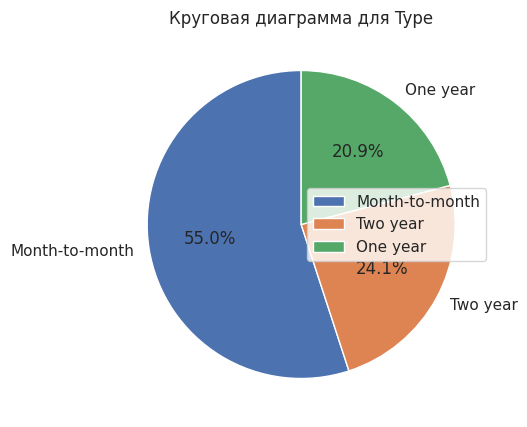

In [19]:
analyze_column(df_contract, 'Type')

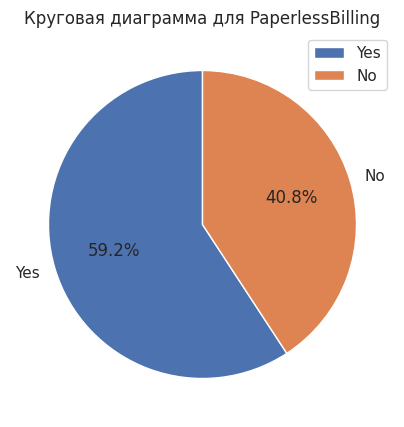

In [20]:
analyze_column(df_contract, 'PaperlessBilling')

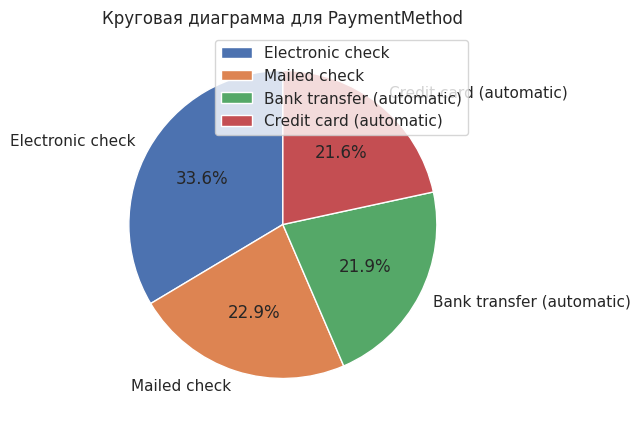

In [21]:
analyze_column(df_contract, 'PaymentMethod')

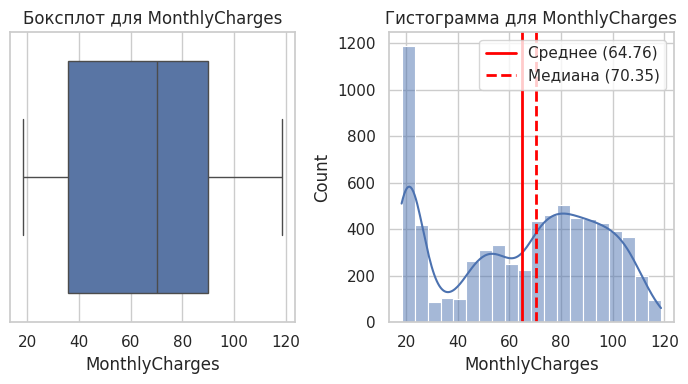

In [22]:
analyze_column(df_contract, 'MonthlyCharges')

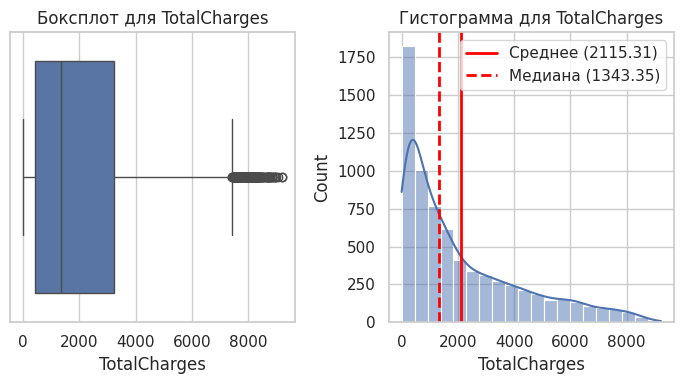

In [23]:
analyze_column(df_contract, 'TotalCharges')

Ознакомимся с природой выбросов

In [24]:
df_contract[df_contract['TotalCharges'] >= 7500]

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,duration,DeltaCharges
17,9959-WOFKT,2014-03-01,No,Two year,No,Bank transfer (automatic),106.70,8257.51,2163,7878.013667
57,5067-XJQFU,2014-08-01,No,One year,Yes,Electronic check,108.45,7730.32,2010,7338.273250
59,5954-BDFSG,2014-02-01,No,Two year,Yes,Credit card (automatic),107.50,7740.00,2191,7354.791667
198,7255-SSFBC,2014-02-01,No,Two year,Yes,Bank transfer (automatic),112.25,8324.46,2191,7904.457917
369,3520-FJGCV,2014-02-01,No,Two year,Yes,Credit card (automatic),112.60,8755.78,2191,8333.154667
...,...,...,...,...,...,...,...,...,...,...
6859,3508-CFVZL,2014-03-01,No,Two year,No,Mailed check,111.30,7902.30,2163,7489.377000
6910,0530-IJVDB,2014-04-01,No,Two year,Yes,Electronic check,114.60,8182.44,2132,7744.668000
6913,8213-TAZPM,2014-05-01,No,One year,Yes,Bank transfer (automatic),108.75,7728.86,2102,7334.641250
6992,0218-QNVAS,2014-03-01,No,One year,No,Bank transfer (automatic),100.55,7638.78,2163,7301.769917


Заметим, что длительность контракта у всех образцов находится значительно правее, относительно медианы, что говорит о натуральности данных.

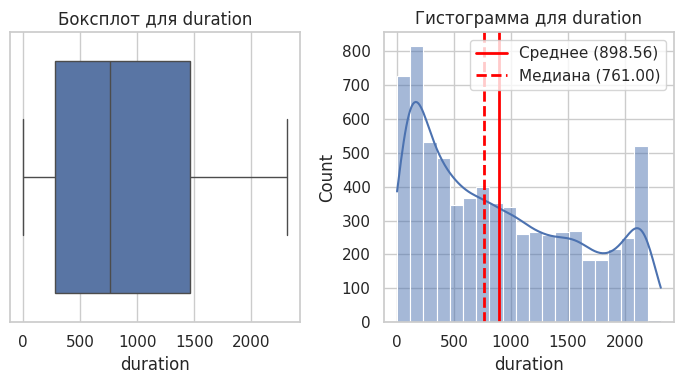

In [25]:
analyze_column(df_contract, 'duration')

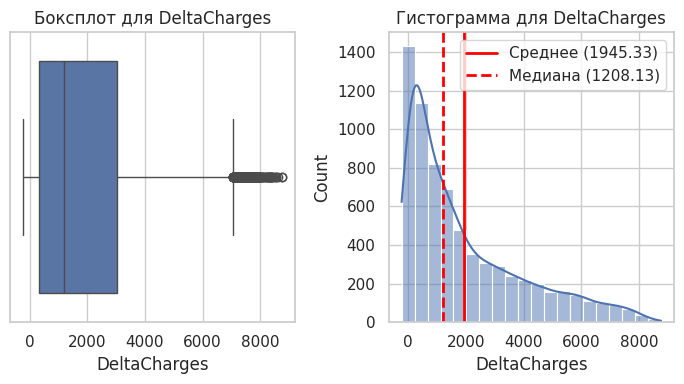

In [26]:
analyze_column(df_contract, 'DeltaCharges')

#### Вывод

Категории распределены равномерно за исключением типа оплаты, где ежемесячные платежи преобладают над годовыми и двухгодовыми.

Количественные столбцы распределены нормально, boxplot указывает на выбросы в столбце TotalCharges, однако эти значения не являются аномалиями.

Так или иначе, при обработке данных для моделирования стоит прибегнуть к скейлингу количественных признаков.

### Таблица `personal`

In [27]:
# Создаём датафрейм
df_personal = pd.read_sql("SELECT * FROM personal;", engine)
df_personal.head(5)

,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No


In [28]:
df_personal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   object
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: object(5)
memory usage: 275.2+ KB


На данный момент все колонки содержат данные типа object, что справедливо и соответствует природе данных.

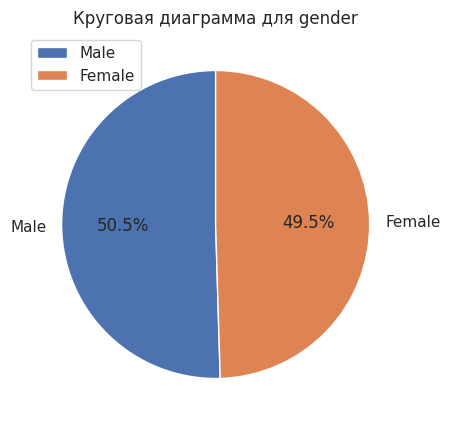

In [29]:
analyze_column(df_personal, 'gender')

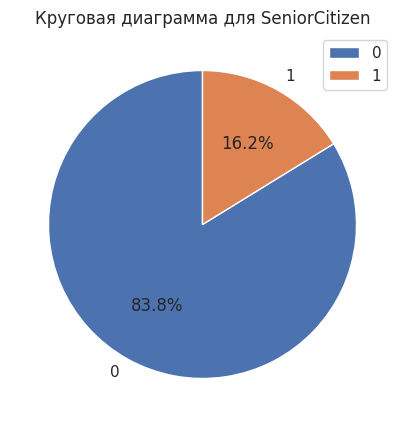

In [30]:
analyze_column(df_personal, 'SeniorCitizen')

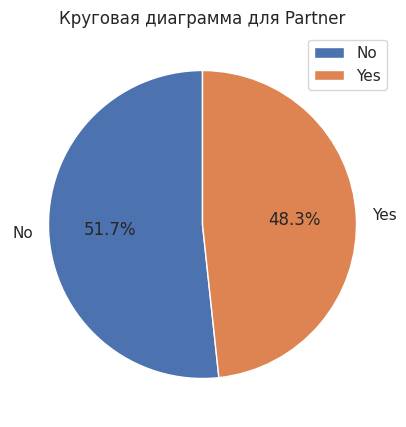

In [31]:
analyze_column(df_personal, 'Partner')

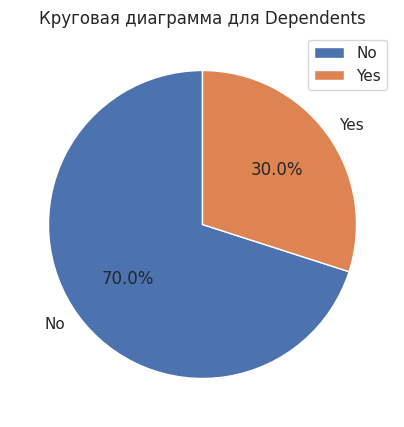

In [32]:
analyze_column(df_personal, 'Dependents')

#### Вывод

Группы распределены равномерно, за исключением столбцов 'SeniorCitizen' и 'Dependents', в выборке только 16% клиентов являются пенсионерами и только у 30% есть дети.

### Таблица `internet`


In [33]:
# Создаём датафрейм
df_internet = pd.read_sql("SELECT * FROM internet;", engine)
df_internet.head(5)

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No


In [34]:
df_internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


Все столбцы содержат тип object, Nan нет.

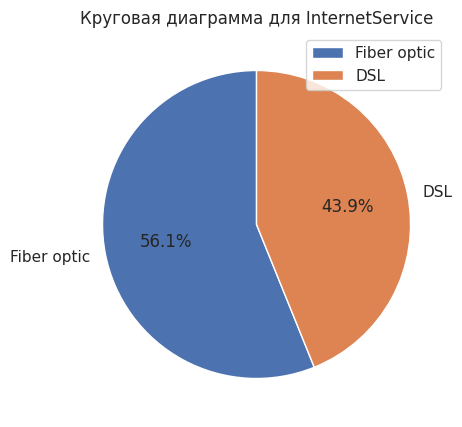

In [35]:
analyze_column(df_internet, 'InternetService')

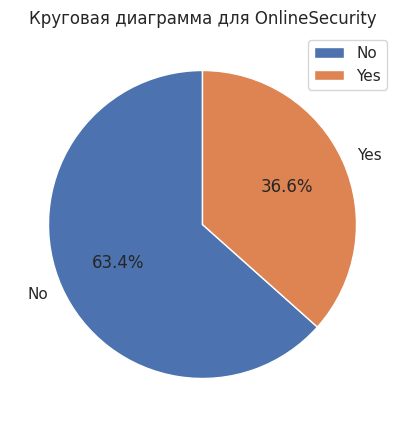

In [36]:
analyze_column(df_internet, 'OnlineSecurity')

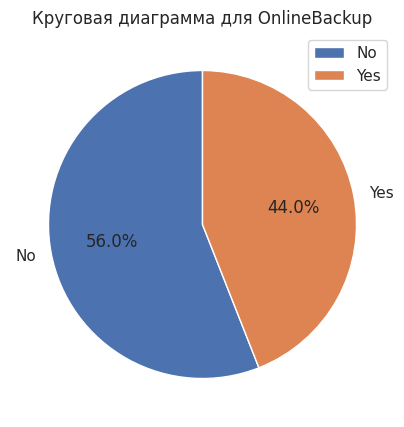

In [37]:
analyze_column(df_internet, 'OnlineBackup')

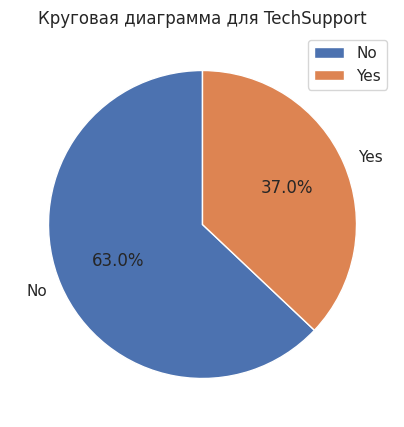

In [38]:
analyze_column(df_internet, 'TechSupport')

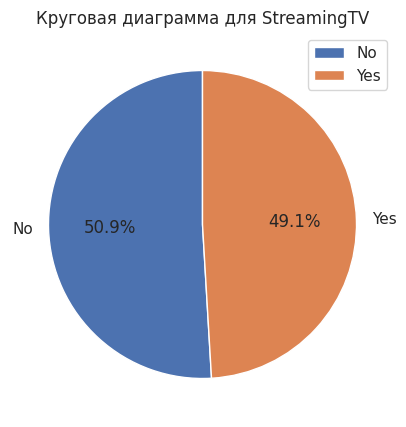

In [39]:
analyze_column(df_internet, 'StreamingTV')

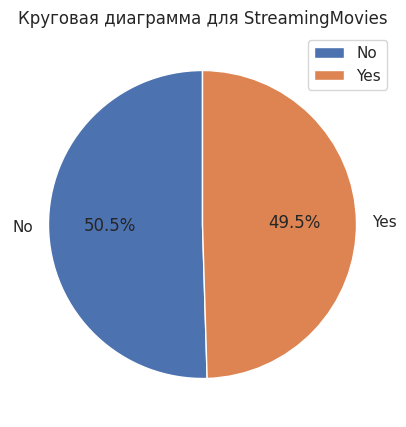

In [40]:
analyze_column(df_internet, 'StreamingMovies')

#### Вывод

Группы пользователей услуг распределены равномерно, Nan и аномалий нет.

### Таблица `phone`


In [41]:
# Создаём датафрейм
df_phone = pd.read_sql("SELECT * FROM phone;", engine)
df_phone.columns = ['customerID','MultipleLines']
df_phone.head(5)

,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes


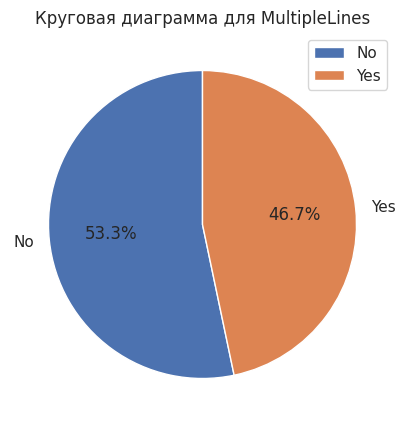

In [42]:
analyze_column(df_phone, 'MultipleLines')

#### Вывод

Группы распределены равномерно.

## **Объединение таблиц**

Все таблицы имеют ключ CustomerId, по которому и будет происходить объединение.

Каждому ID должно соответствовать одно наблюдение (одна строка), для начала проверим наличие дубликатов ID в таблицах:

In [43]:
# Ищем дубликаты
print(df_contract['customerID'].duplicated().sum())
print(df_personal['customerID'].duplicated().sum())
print(df_internet['customerID'].duplicated().sum())
print(df_phone['customerID'].duplicated().sum())

0
0
0
0


Дубликаты не найдены, можно объединять.

In [44]:
# Пример объединения таблиц по столбцу clientID
df = (
    df_contract
    .merge(df_personal, on='customerID', how='outer')
    .merge(df_internet, on='customerID', how='outer')
    .merge(df_phone, on='customerID', how='outer')
)

# Вывод результата
df.head(5)

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,duration,DeltaCharges,...,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
0,0002-ORFBO,2019-05-01,No,One year,Yes,Mailed check,65.6,631.73,276,488.284667,...,Yes,Yes,DSL,No,Yes,No,Yes,Yes,No,No
1,0003-MKNFE,2019-05-01,No,Month-to-month,No,Mailed check,59.9,539.10,276,419.499667,...,No,No,DSL,No,No,No,No,No,Yes,Yes
2,0004-TLHLJ,2019-09-01,No,Month-to-month,Yes,Electronic check,73.9,406.45,153,224.409667,...,No,No,Fiber optic,No,No,Yes,No,No,No,No
3,0011-IGKFF,2018-12-01,No,Month-to-month,Yes,Electronic check,98.0,1372.00,427,1051.866667,...,Yes,No,Fiber optic,No,Yes,Yes,No,Yes,Yes,No
4,0013-EXCHZ,2019-09-01,No,Month-to-month,Yes,Mailed check,83.9,444.67,153,210.029667,...,Yes,No,Fiber optic,No,No,No,Yes,Yes,No,No


In [45]:
# Количество дубликатов в итоговой таблице
df['customerID'].duplicated().sum()

np.int64(0)

In [46]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 22 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   float64
 8   duration          7043 non-null   int64  
 9   DeltaCharges      7043 non-null   float64
 10  gender            7043 non-null   object 
 11  SeniorCitizen     7043 non-null   object 
 12  Partner           7043 non-null   object 
 13  Dependents        7043 non-null   object 
 14  InternetService   5517 non-null   object 
 15  OnlineSecurity    5517 non-null   object 
 16  OnlineBackup      5517 non-null   object 


Столбцы InternetService, OnlineSecurity, OnlineBackup, DeviceProtection, TechSupport, StreamingTV, StreamingMovies и MultipleLines содержат Nan.

Скорее всего это вызвано тем, что не все клиенты используют интернет услуги, т.к. это дополнительный пакет, поэтому следует создать дополнительную категорию, которой мы заменим Nan, назовём её IPnU (internet package not used)

In [47]:
# Заменим Nan
df[['InternetService',
       'OnlineSecurity',
       'OnlineBackup',
       'DeviceProtection',
       'TechSupport',
       'StreamingTV',
       'StreamingMovies',
       'MultipleLines']] = \
df[['InternetService',
       'OnlineSecurity',
       'OnlineBackup',
       'DeviceProtection',
       'TechSupport',
       'StreamingTV',
       'StreamingMovies',
       'MultipleLines']].fillna('IPnU')

In [48]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 22 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   float64
 8   duration          7043 non-null   int64  
 9   DeltaCharges      7043 non-null   float64
 10  gender            7043 non-null   object 
 11  SeniorCitizen     7043 non-null   object 
 12  Partner           7043 non-null   object 
 13  Dependents        7043 non-null   object 
 14  InternetService   7043 non-null   object 
 15  OnlineSecurity    7043 non-null   object 
 16  OnlineBackup      7043 non-null   object 


Целевым признаком должен сделаем столбец 'EndDate', переведём его в бинарный формат, где 1 - клиент расторг контракт (в датасете есть дата EndDate), а 0 - клиент не расторгал контракт ('No' в оригинальном столбце EndDate)

In [49]:
df['IsTerminated'] = [0 if x == 'No' else 1 for x in df['EndDate']]

Данные объединены, перед подготовкой рассмотрим матрицу корреляций признаков, чтобы избежать мультиколлениарности и рассмотреть зависимости.

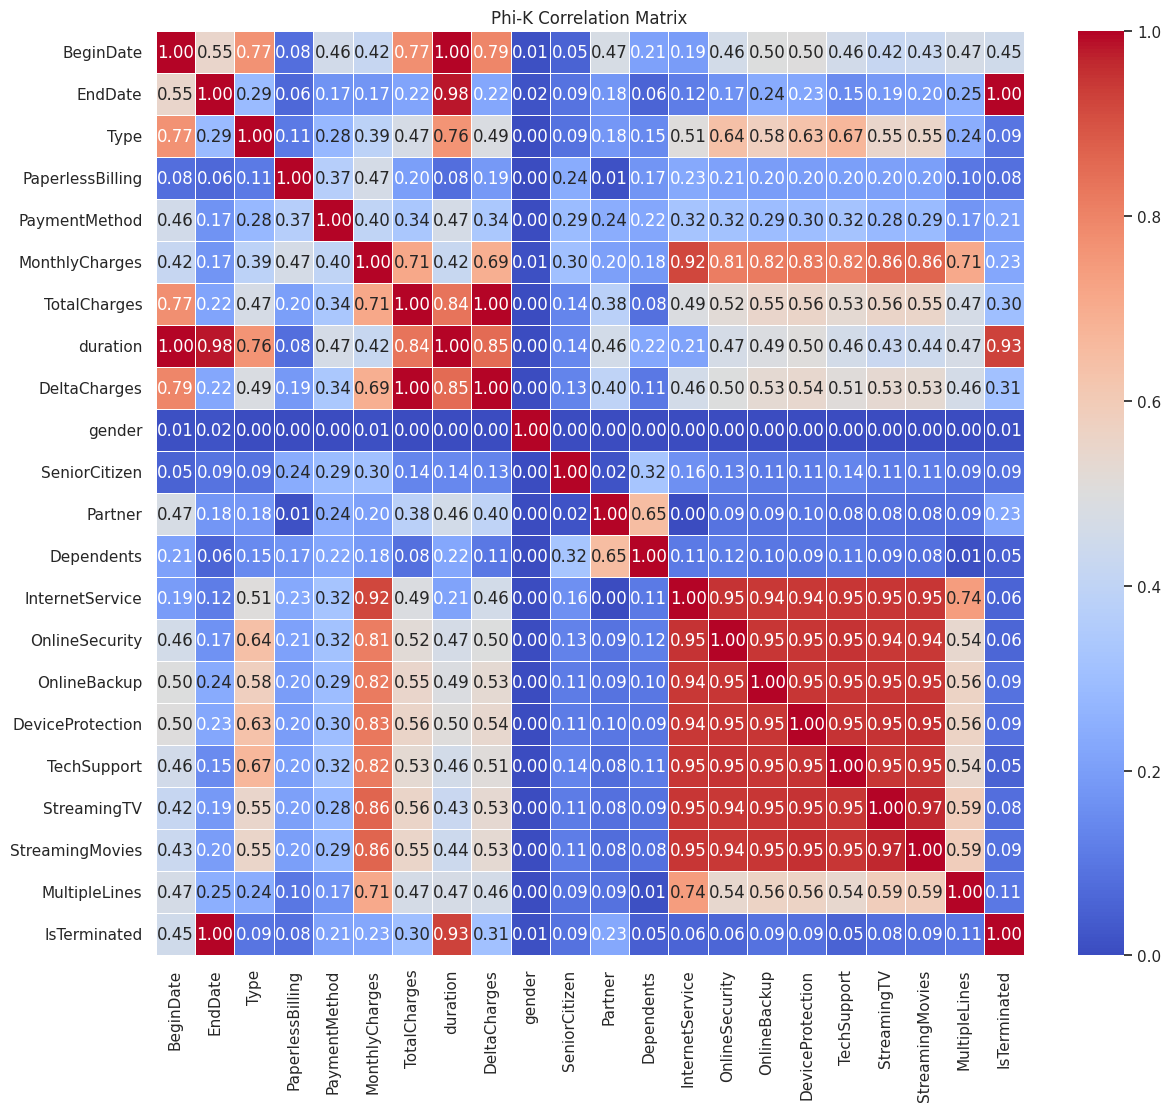

In [50]:
phik_corr = df.drop('customerID',axis=1).phik_matrix(
    interval_cols=['MonthlyCharges',
                   'TotalCharges',
                   'DeltaCharges'])

# Визуализация с помощью seaborn
plt.figure(figsize=(14, 12))
sns.heatmap(phik_corr, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title("Phi-K Correlation Matrix")
plt.show()

В глаза бросается явная мультиколлинеарность признаков, в которых была проведена замена Nan. Так или иначе, далее мы будем использовать LabelEncoding для подготовки признаков в бустинг/древо решений, что решит эту проблему.

Столбец MonthlyCharges коррелирует сразу с несколькими дуригими признаками: InternetService, StreamingTV и StreamingMovies. Это логично, ведь дополнительные услуги приводят к повышению тарифа, но столбец MonthlyCharges нужно убрать из обучающей выборки. При этом производная столбца DeltaCharges не имеет высокой корреляции ни с одним из столбцов, которые будут участвовать в обучении, так что, даже при удалении, MonthlyCharges принесёт обучению пользу.

### **EDA итоговой выборки**

Таблица для обучения и теста составлена, перед обучением вторично рассмотрим данные:

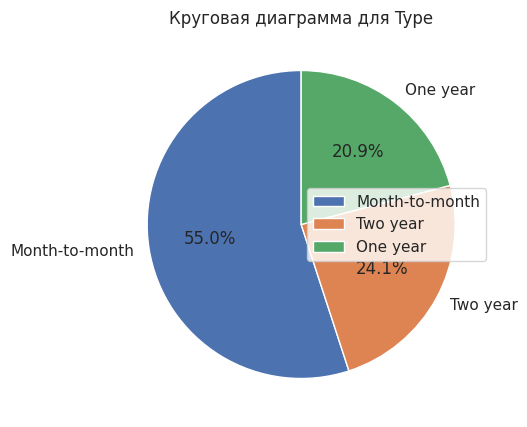

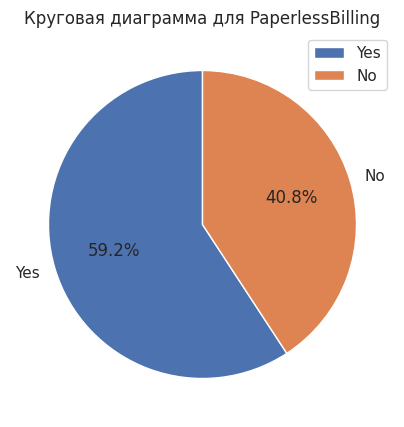

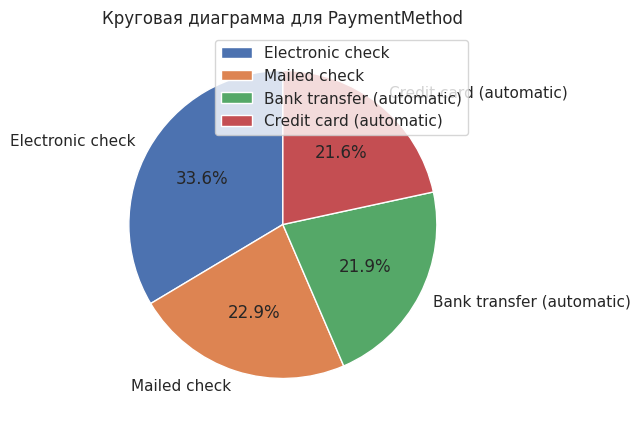

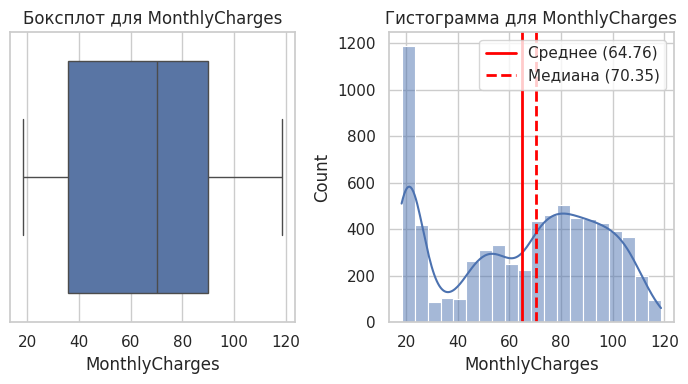

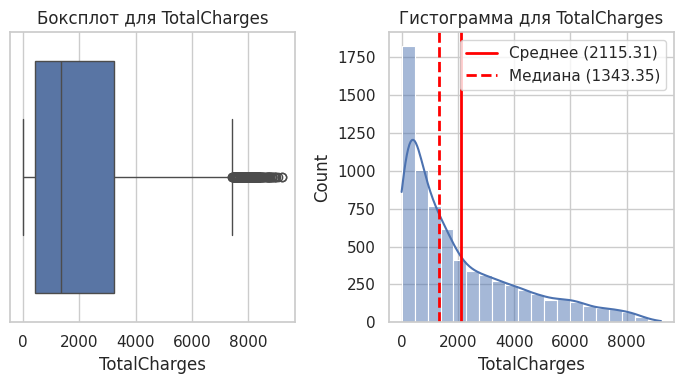

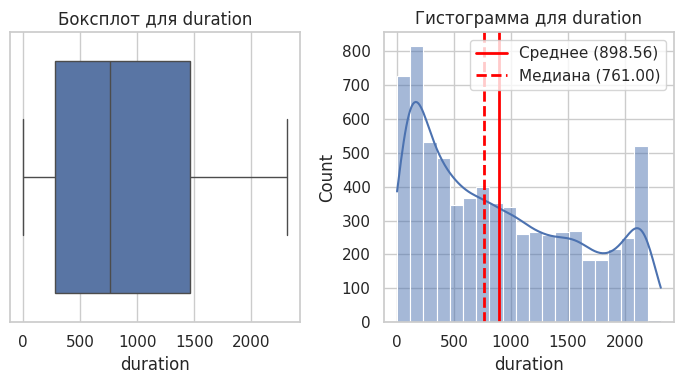

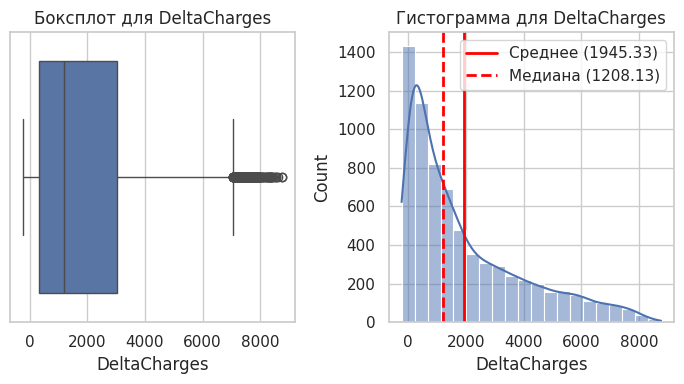

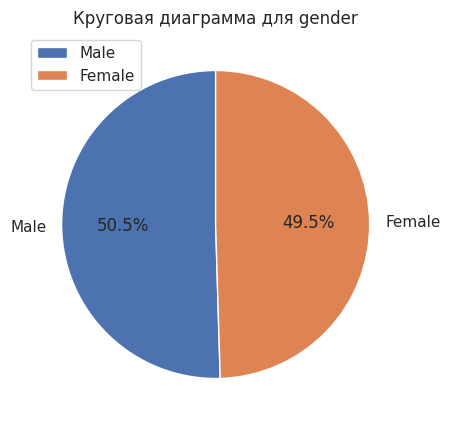

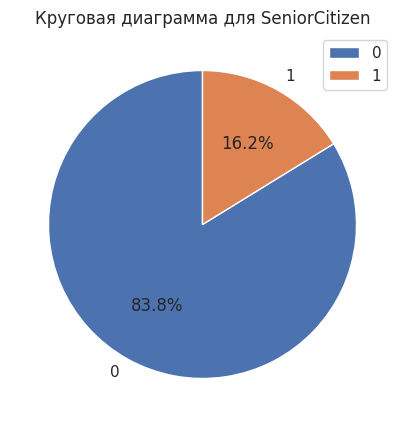

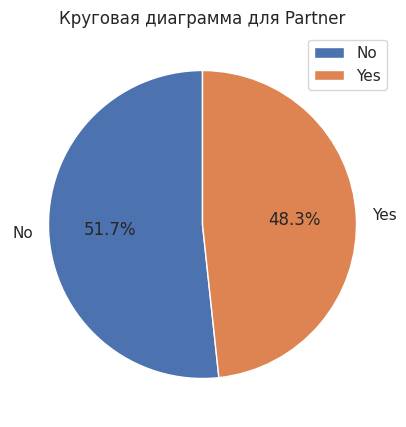

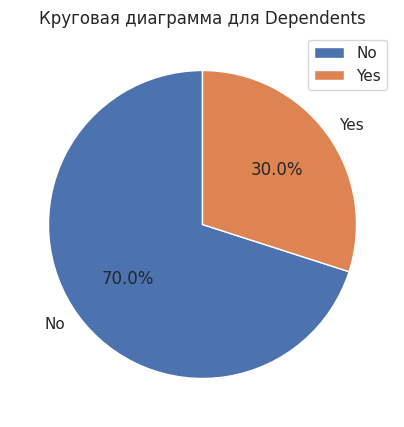

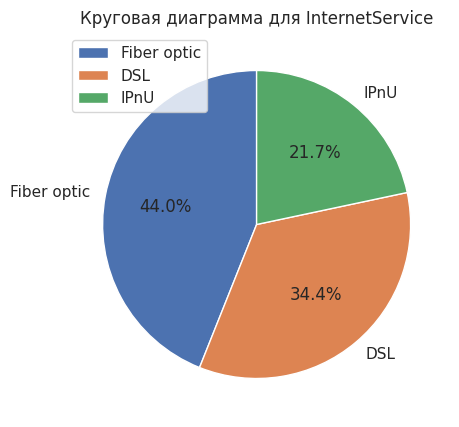

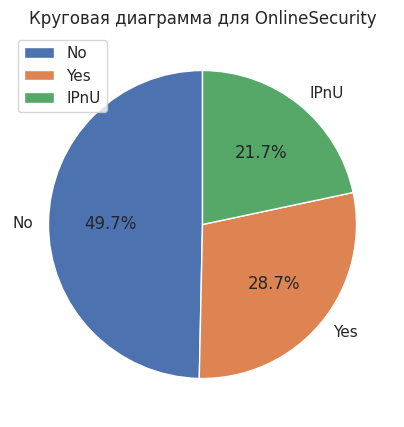

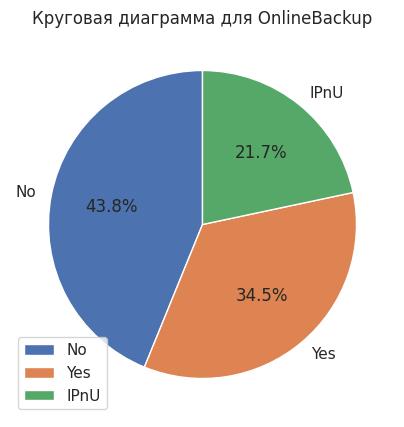

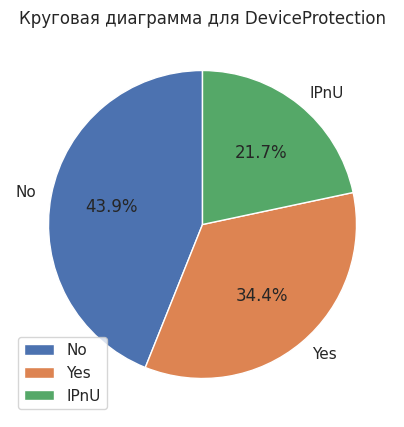

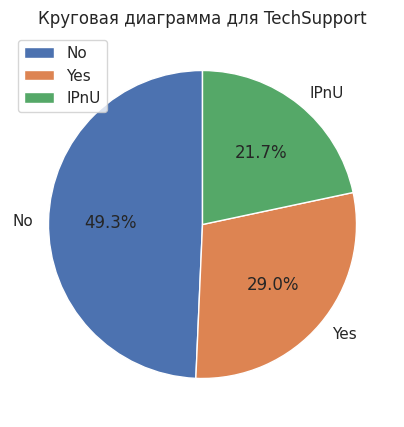

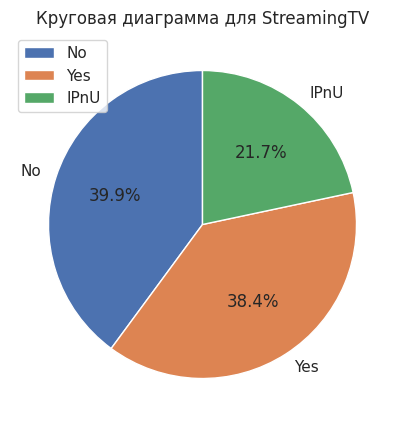

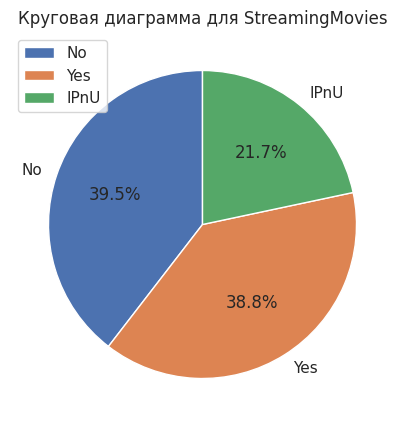

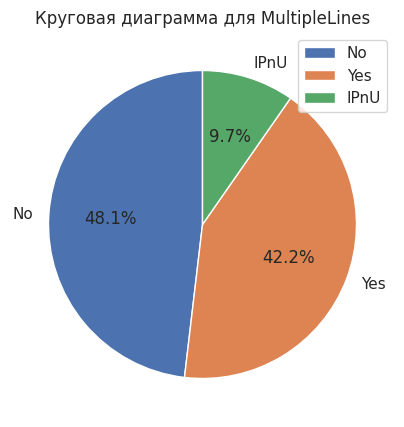

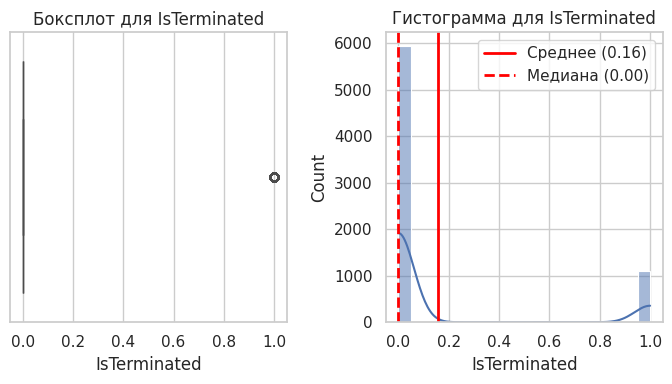

In [51]:
for i in df.drop(['customerID',
                  'EndDate',
                  'BeginDate'], axis=1).columns:
    analyze_column(df, i)

Общая картина, за исключением признаков, где были заменены Nan, остаётся прежней.

## **Предобработка данных**

In [52]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 23 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   float64
 8   duration          7043 non-null   int64  
 9   DeltaCharges      7043 non-null   float64
 10  gender            7043 non-null   object 
 11  SeniorCitizen     7043 non-null   object 
 12  Partner           7043 non-null   object 
 13  Dependents        7043 non-null   object 
 14  InternetService   7043 non-null   object 
 15  OnlineSecurity    7043 non-null   object 
 16  OnlineBackup      7043 non-null   object 


In [53]:
df.head(5)

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,duration,DeltaCharges,...,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines,IsTerminated
0,0002-ORFBO,2019-05-01,No,One year,Yes,Mailed check,65.6,631.73,276,488.284667,...,Yes,DSL,No,Yes,No,Yes,Yes,No,No,0
1,0003-MKNFE,2019-05-01,No,Month-to-month,No,Mailed check,59.9,539.10,276,419.499667,...,No,DSL,No,No,No,No,No,Yes,Yes,0
2,0004-TLHLJ,2019-09-01,No,Month-to-month,Yes,Electronic check,73.9,406.45,153,224.409667,...,No,Fiber optic,No,No,Yes,No,No,No,No,0
3,0011-IGKFF,2018-12-01,No,Month-to-month,Yes,Electronic check,98.0,1372.00,427,1051.866667,...,No,Fiber optic,No,Yes,Yes,No,Yes,Yes,No,0
4,0013-EXCHZ,2019-09-01,No,Month-to-month,Yes,Mailed check,83.9,444.67,153,210.029667,...,No,Fiber optic,No,No,No,Yes,Yes,No,No,0


Рассмотрим также и дисбаланс классов

In [54]:
# Разделение признаков и целевой переменной
X = df.drop(columns=['customerID',
                     'BeginDate',
                     'EndDate',
                     'IsTerminated',
                     'MonthlyCharges',
                     'TotalCharges'])  # Убираем ненужные столбцы
y = df['IsTerminated']  # Целевая переменная

print(y.value_counts(normalize=True))

IsTerminated
0    0.843675
1    0.156325
Name: proportion, dtype: float64


Дисбаланс классов: в 84 процентах наблюдений содержится класс 0, когда класс 1 содержится только в 16 процентах. Попробуем сгладить дисбаланс применением стратификации при разделении данных на выборки.

Переведём данные в векторное представление, используя OneHotEncoder, количественные столбцы масштабируем через StandardScaler.

In [55]:
# Разбиение на train/test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=RS, stratify=y
)

Создадим два пайплайна предобработки: для decision tree исользуем ordinal encoder, а для линейной модели и нейросети OHE.

In [56]:
# Определение категориальных и числовых признаков
categorical_columns = X.select_dtypes(include='object').columns
numerical_columns = X.select_dtypes(include='number').columns

# Создание пайплайна для древа решений
ord_preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_columns),
        ('cat', OrdinalEncoder(
         handle_unknown='use_encoded_value',unknown_value=-1),
         categorical_columns)
    ]
)

# Создание пайплайна для линейной модели и нейросети
ohe_preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_columns),
        ('cat', OneHotEncoder(
         handle_unknown='ignore',
         drop='first',
         sparse_output=False),
         categorical_columns)
    ]
)

Выборки и пайплайн обработки составлены, таргет выделен – можем приступать к обучению моделей.

## Обучение моделей

### Логистическая регрессия

ROC-AUC = 0.76

In [57]:
logreg_pipeline = Pipeline(steps=[
    ('preprocessor', ohe_preprocessor),
    ('classifier', LogisticRegression(solver='liblinear', random_state=RS))
])

logreg_params = {
    'classifier__C': [0.01, 0.1, 1, 10],  # Регуляризация
    'classifier__penalty': ['l1', 'l2']
}

logreg_search = GridSearchCV(
    logreg_pipeline, logreg_params, cv=StratifiedKFold(5), scoring='roc_auc', n_jobs=-1
)
logreg_search.fit(X_train, y_train)
print("Best Logistic Regression ROC-AUC:", logreg_search.best_score_)

Best Logistic Regression ROC-AUC: 0.7654122164246969


### Decision Tree

ROC-AUC = 0.78

In [58]:
tree_pipeline = Pipeline(steps=[
    ('preprocessor', ord_preprocessor),
    ('classifier', DecisionTreeClassifier(random_state=RS))
])

tree_params = {
    'classifier__max_depth': [3, 5, 10, None],
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__min_samples_leaf': [1, 2, 4]
}

tree_search = GridSearchCV(
    tree_pipeline, tree_params, cv=StratifiedKFold(5), scoring='roc_auc', n_jobs=-1
)
tree_search.fit(X_train, y_train)
print("Best Decision Tree ROC-AUC:", tree_search.best_score_)

Best Decision Tree ROC-AUC: 0.7861668925651476


### Градиентный бустинг

ROC-AUC = 0.84

Усложним алгоритм предскзаания, используя библиотеку CatBoost. Она имеет широкий потенциал тюнинга модели, поэтому используем кросс-валидацию Optuna для поиска гиперпараметров:

In [59]:
# Определение категориальных признаков
categorical_columns = X.select_dtypes(include=['object']).columns.tolist()

# Функция для оптимизации гиперпараметров через Optuna
def objective(trial):
    # Гиперпараметры для оптимизации
    param = {
        "iterations": trial.suggest_int("iterations", 300, 800),  # Снизили макс. итерации для скорости
        "depth": trial.suggest_int("depth", 2, 5),  # Уменьшили глубину, т.к. данных мало
        "learning_rate": trial.suggest_float("learning_rate", 0.005, 0.05, log=True),  # Скорректировали диапазон
        "l2_leaf_reg": trial.suggest_float("l2_leaf_reg", 3, 6, log=True),  # Чуть увеличили регуляризацию
        "bagging_temperature": trial.suggest_float("bagging_temperature", 0.1, 1.0),  # Расширили диапазон (больше случайности)
        "random_strength": trial.suggest_float("random_strength", 0.3, 0.8),  # Усилили случайность сплитов
        "border_count": trial.suggest_int("border_count", 16, 64),  # Уменьшили число бинов, т.к. много категориальных фичей
    }


    # Создаём модель CatBoostClassifier
    cb_model = CatBoostClassifier(
        eval_metric="AUC",
        random_seed=RS,
        cat_features=categorical_columns,  # Передаём список категориальных признаков
        verbose=0,
        **param
    )

    # Кросс-валидация StratifiedKFold
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=RS)
    auc_scores = []

    for train_idx, val_idx in skf.split(X_train, y_train):
        X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

        # Обучаем модель на обучающей выборке
        cb_model.fit(
            X_tr, y_tr,
            eval_set=(X_val, y_val),
            early_stopping_rounds=50,
            use_best_model=True
        )

        # Предсказание вероятностей на валидации
        y_val_pred_prob = cb_model.predict_proba(X_val)[:, 1]

        # ROC-AUC на валидации
        auc_scores.append(roc_auc_score(y_val, y_val_pred_prob))

    # Среднее значение ROC-AUC по фолдам
    return np.mean(auc_scores)

In [60]:
# Устанавливаем random state для Optuna
sampler = optuna.samplers.TPESampler(seed=RS)

# Запуск Optuna для подбора гиперпараметров
study = optuna.create_study(direction="maximize", sampler=sampler)
study.optimize(objective, n_trials=30, n_jobs=-1)

# Вывод лучших параметров
print("Лучшие параметры:", study.best_params)
print("Лучший средний ROC-AUC на кросс-валидации:", study.best_value)

[I 2026-01-29 18:37:28,399] A new study created in memory with name: no-name-b20cbdbf-ec1c-4da8-b9f8-d4823ffc603d
[I 2026-01-29 18:37:46,701] Trial 1 finished with value: 0.8317643964314462 and parameters: {'iterations': 432, 'depth': 3, 'learning_rate': 0.04914713262596167, 'l2_leaf_reg': 4.807198922948624, 'bagging_temperature': 0.7457268725268311, 'random_strength': 0.737223927728921, 'border_count': 19}. Best is trial 1 with value: 0.8317643964314462.
[I 2026-01-29 18:37:49,438] Trial 0 finished with value: 0.8310740098555744 and parameters: {'iterations': 347, 'depth': 3, 'learning_rate': 0.017422349890617986, 'l2_leaf_reg': 3.6027703088213863, 'bagging_temperature': 0.41657477691040046, 'random_strength': 0.7681256521134933, 'border_count': 38}. Best is trial 1 with value: 0.8317643964314462.
[I 2026-01-29 18:38:13,414] Trial 3 finished with value: 0.7950733938585113 and parameters: {'iterations': 690, 'depth': 4, 'learning_rate': 0.005322386370577944, 'l2_leaf_reg': 4.0398167536

Лучшие параметры: {'iterations': 714, 'depth': 5, 'learning_rate': 0.021278195182836745, 'l2_leaf_reg': 3.032575146435222, 'bagging_temperature': 0.5173215742924551, 'random_strength': 0.44102760505353034, 'border_count': 63}
Лучший средний ROC-AUC на кросс-валидации: 0.8350764375349904


ROC-AUC на валидационной выборке составил 0.84, что на 0.06 больше результата базовой модели – прогресс на лицо.

### Нейронная сеть
ROC-AUC = 0.82

In [61]:
# Инициализация трансформеров
ohe = OneHotEncoder(handle_unknown='ignore', drop='first', sparse_output=False)
scaler = StandardScaler()

# OHE для категориальных признаков
ohe_encoded = ohe.fit_transform(X[categorical_columns])
ohe_feature_names = ohe.get_feature_names_out(categorical_columns)  # Получаем новые названия колонок
X_ohe = pd.DataFrame(ohe_encoded, columns=ohe_feature_names, index=X.index)  # Преобразуем в DataFrame

# StandardScaler для числовых признаков
X_scaled = pd.DataFrame(scaler.fit_transform(X[numerical_columns]), columns=numerical_columns, index=X.index)

# Объединяем обработанные признаки
X_processed = pd.concat([X_ohe, X_scaled], axis=1)

In [62]:
# Кросс-валидация
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=RS)
auc_scores = []

for train_index, val_index in skf.split(X_processed, y):
    X_train_nn, X_val = X_processed.iloc[train_index], X_processed.iloc[val_index]
    y_train_nn, y_val = y.iloc[train_index], y.iloc[val_index]

    # Создание улучшенной нейросети
    model = Sequential([
        Dense(32, input_dim=X_train_nn.shape[1], activation='relu', kernel_regularizer='l2'),
        Dropout(0.3),

        Dense(32, activation='relu', kernel_regularizer='l2'),
        Dropout(0.3),

        Dense(16, activation='relu', kernel_regularizer='l2'),
        Dropout(0.2),

        Dense(1, activation='sigmoid')
    ])

    # Компиляция модели
    model.compile(optimizer=Adam(learning_rate=0.003),
                  loss='binary_crossentropy',
                  metrics=[tf.keras.metrics.AUC(curve='ROC')])

    # Callback для уменьшения learning rate
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6, verbose=1)

    # Обучение модели с class_weight
    history = model.fit(
        X_train_nn, y_train_nn,
        epochs=25,
        batch_size=32,
        validation_data=(X_val, y_val),
        callbacks=[reduce_lr],
        verbose=3
    )

    # Оценка на валидации
    y_pred = model.predict(X_val).ravel()  # Превращаем в 1D массив
    roc_auc = roc_auc_score(y_val, y_pred)
    auc_scores.append(roc_auc)

    print(f'Fold ROC-AUC: {roc_auc:.4f}')

# Средний ROC-AUC по фолдам
print(f'Средний ROC-AUC: {np.mean(auc_scores):.4f}')

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/25
Epoch 2/25
Epoch 3/25
Epoch 4/25
Epoch 5/25
Epoch 6/25
Epoch 7/25
Epoch 8/25
Epoch 9/25
Epoch 10/25
Epoch 11/25
Epoch 12/25
Epoch 13/25
Epoch 14/25
Epoch 15/25
Epoch 16/25
Epoch 17/25
Epoch 18/25
Epoch 19/25
Epoch 20/25
Epoch 21/25
Epoch 22/25
Epoch 23/25

Epoch 23: ReduceLROnPlateau reducing learning rate to 0.001500000013038516.
Epoch 24/25
Epoch 25/25
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
Fold ROC-AUC: 0.8438
Epoch 1/25


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 2/25
Epoch 3/25
Epoch 4/25
Epoch 5/25
Epoch 6/25
Epoch 7/25
Epoch 8/25
Epoch 9/25
Epoch 10/25
Epoch 11/25
Epoch 12/25
Epoch 13/25
Epoch 14/25
Epoch 15/25
Epoch 16/25
Epoch 17/25
Epoch 18/25
Epoch 19/25
Epoch 20/25
Epoch 21/25
Epoch 22/25
Epoch 23/25
Epoch 24/25
Epoch 25/25
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
Fold ROC-AUC: 0.8171
Epoch 1/25


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 2/25
Epoch 3/25
Epoch 4/25
Epoch 5/25
Epoch 6/25
Epoch 7/25
Epoch 8/25
Epoch 9/25
Epoch 10/25
Epoch 11/25
Epoch 12/25
Epoch 13/25
Epoch 14/25
Epoch 15/25
Epoch 16/25
Epoch 17/25
Epoch 18/25
Epoch 19/25
Epoch 20/25
Epoch 21/25
Epoch 22/25
Epoch 23/25
Epoch 24/25

Epoch 24: ReduceLROnPlateau reducing learning rate to 0.001500000013038516.
Epoch 25/25
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
Fold ROC-AUC: 0.8085
Epoch 1/25


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 2/25
Epoch 3/25
Epoch 4/25
Epoch 5/25
Epoch 6/25
Epoch 7/25
Epoch 8/25
Epoch 9/25
Epoch 10/25
Epoch 11/25
Epoch 12/25
Epoch 13/25
Epoch 14/25
Epoch 15/25
Epoch 16/25
Epoch 17/25
Epoch 18/25
Epoch 19/25
Epoch 20/25
Epoch 21/25
Epoch 22/25
Epoch 23/25
Epoch 24/25
Epoch 25/25
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Fold ROC-AUC: 0.8151
Epoch 1/25


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 2/25
Epoch 3/25
Epoch 4/25
Epoch 5/25
Epoch 6/25
Epoch 7/25
Epoch 8/25
Epoch 9/25
Epoch 10/25
Epoch 11/25
Epoch 12/25
Epoch 13/25
Epoch 14/25
Epoch 15/25
Epoch 16/25
Epoch 17/25
Epoch 18/25
Epoch 19/25

Epoch 19: ReduceLROnPlateau reducing learning rate to 0.001500000013038516.
Epoch 20/25
Epoch 21/25
Epoch 22/25
Epoch 23/25
Epoch 24/25
Epoch 25/25
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Fold ROC-AUC: 0.8293
Средний ROC-AUC: 0.8228


Применение нейросети не дало роста метрики.

## Тестирование модели

Протестируем лучшую по кросс-валидации модель (CatBoost)

In [63]:
# Обучение финальной модели с лучшими параметрами
best_params = study.best_params
final_model = CatBoostClassifier(
    **best_params,
    eval_metric="AUC",
    random_seed=RS,
    cat_features=categorical_columns,
    verbose=100
)

final_model.fit(X_train, y_train, eval_set=(X_test, y_test), early_stopping_rounds=150, use_best_model=True)

# Оценка финальной модели
y_pred_final = final_model.predict_proba(X_test)[:, 1]
final_auc = roc_auc_score(y_test, y_pred_final)
print(f"Финальный ROC-AUC: {final_auc:.4f}")

0:	test: 0.7238334	best: 0.7238334 (0)	total: 14.9ms	remaining: 10.6s
100:	test: 0.8282907	best: 0.8282907 (100)	total: 2.07s	remaining: 12.6s
200:	test: 0.8344047	best: 0.8345002 (178)	total: 3.36s	remaining: 8.57s
300:	test: 0.8365741	best: 0.8366230 (297)	total: 4.4s	remaining: 6.04s
400:	test: 0.8384094	best: 0.8384094 (400)	total: 5.52s	remaining: 4.31s
500:	test: 0.8403499	best: 0.8403499 (500)	total: 6.63s	remaining: 2.82s
600:	test: 0.8414254	best: 0.8416432 (593)	total: 7.73s	remaining: 1.45s
700:	test: 0.8428521	best: 0.8429181 (699)	total: 8.86s	remaining: 164ms
713:	test: 0.8430283	best: 0.8430527 (708)	total: 9.03s	remaining: 0us

bestTest = 0.8430527346
bestIteration = 708

Shrink model to first 709 iterations.
Финальный ROC-AUC: 0.8431


Рассмотрим так же метрику accuracy, чтобы понимать общую точность модели.

In [64]:
pred = np.array(y_pred_final) >= 0.5
pred = pred.astype(int)
print(f'accuracy на тесте: {accuracy_score(y_test, pred)}')

accuracy на тесте: 0.8733674048835889


accuracy в 0.87 говорит о том, что модель правильно присвоила 87% меток из тестового набора.

Для полноты картины рассмотрим матрицу ошибок модели

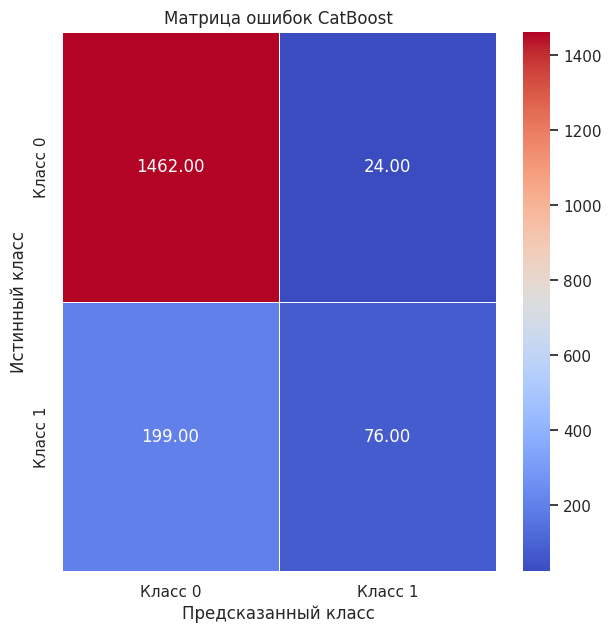

In [65]:
# Вычисляем матрицу ошибок
cm = confusion_matrix(y_test, pred)

plt.figure(figsize=(7, 7))
sns.heatmap(cm,
            annot=True,
            cmap='coolwarm',
            fmt='.2f',
            linewidths=0.5,
            xticklabels=["Класс 0", "Класс 1"],
            yticklabels=["Класс 0", "Класс 1"])
plt.xlabel("Предсказанный класс")
plt.ylabel("Истинный класс")
plt.title("Матрица ошибок CatBoost")
plt.show()

В нашей задаче бинарной классификации разрыва контракта клиентом `(IsTerminated: 1 - ушёл, 0 - остался)` получилась следующая матрица ошибок:

\begin{bmatrix}
1465 & 21 \\
209 & 66
\end{bmatrix}

Где:

1465 — True Negative (TN) → 892 клиента остались, и модель правильно предсказала, что они не ушли.

21 — False Positive (FP) → 21 случай ложного указания ухода клиента

209 — False Negative (FN) → 165 клиентов ушли, но модель предсказала, что они останутся.

66 — True Positive (TP) → 66 случаев правильного указания клиентов.

**Следует заметить, что передвижение порога классов могло бы улучшить точность модели по классу 1 даже в услоиях дисбаланса, однако целевая метрика ROC-AUC не требует этих манипуляций.**

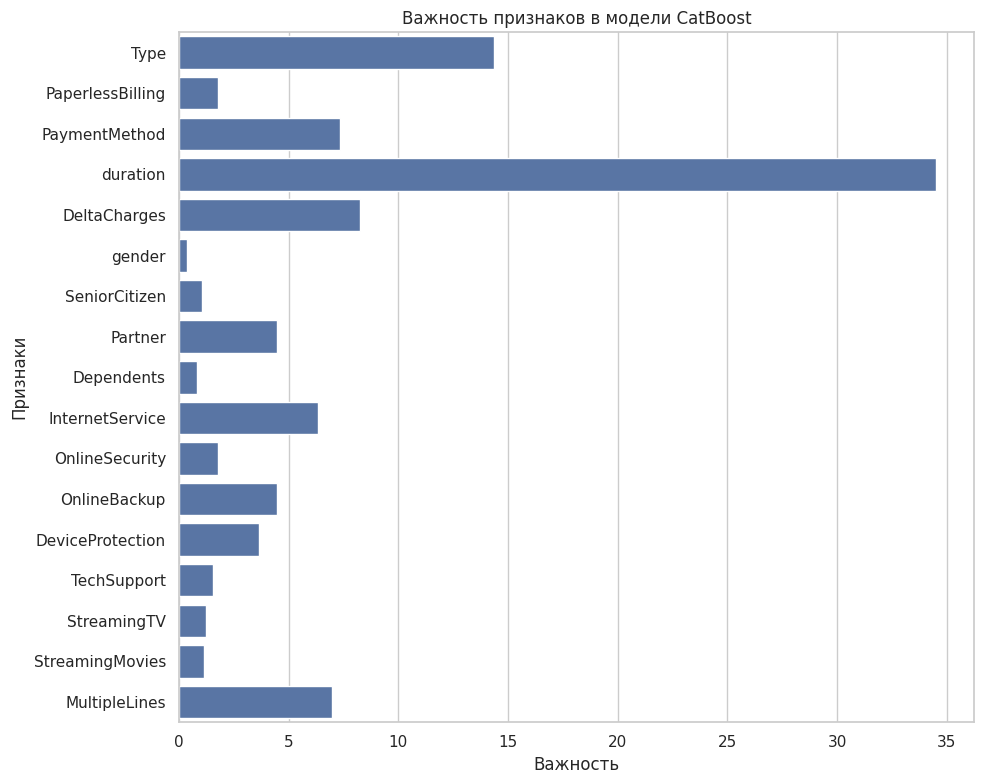

In [66]:
# Визуализация важности признаков
feature_importances = final_model.get_feature_importance()
features = X_train.columns

imp_s = pd.Series(feature_importances,index=features)

# Построение графика
plt.figure(figsize=(10, 8))
sns.barplot(x=feature_importances, y=features)
plt.title("Важность признаков в модели CatBoost")
plt.xlabel("Важность")
plt.ylabel("Признаки")
plt.tight_layout()
plt.show()

In [67]:
imp_s

,0
Type,14.352245
PaperlessBilling,1.770673
PaymentMethod,7.347305
duration,34.519803
DeltaCharges,8.269147
gender,0.376756
SeniorCitizen,1.035715
Partner,4.449010
Dependents,0.796122
InternetService,6.314141


**Проведём интерпретацию весов:**

**Наиболее значимые признаки:**

`duration (44.14):`

Самый высокий вес имеет признак «duration». Это означает, что продолжительность действия договора (или время сотрудничества) является ключевым фактором в решении о том, останется клиент или уйдёт. Возможно, клиенты с короткими договорами (или недавними подключениями) подвержены большему риску ухода.

`Type (12.14):`

Тип оплаты (ежемесячно, ежегодно и т.п.) также играет значительную роль. Различия в типе оплаты могут отражать степень лояльности или финансовые предпочтения, что сказывается на вероятности ухода.

`DeltaCharges (9.63)`:

Этот признак (разница между ожидаемыми и фактическими расходами) тоже важен для модели. Он может сигнализировать о том, что резкие изменения в суммах платежей или несоответствия в счётах влияют на решение клиента об уходе.

`MultipleLines (7.35)`:

Наличие подключения телефона к нескольким линиям также имеет высокую значимость. Это может быть связано с особенностями использования услуг или сложностью тарифных планов, что потенциально влияет на удовлетворённость клиентов.

**Признаки среднего влияния:**

`PaymentMethod (4.67)`, `Partner (4.10)`, `InternetService (3.82)`, `OnlineBackup (3.42)`, `StreamingMovies (3.07)`:

Эти признаки имеют умеренные веса, что говорит о том, что способ оплаты, наличие партнёра, тип интернет-соединения и дополнительные сервисы (облачное хранилище, каталог фильмов) играют определённую, но не первостепенную роль в прогнозировании оттока.
PaymentMethod и тип подключения (`InternetService`) указывают на то, что выбор способа оплаты и характера услуг может влиять на удовлетворённость клиента.

**Менее значимые признаки:**

`PaperlessBilling (1.29)`, `OnlineSecurity (1.06)`, `DeviceProtection (1.66)`, `TechSupport (0.69)`, `StreamingTV (1.51)`:

Хотя эти признаки и учитываются моделью, их влияние существенно ниже, что говорит о сравнительно меньшей информативности для предсказания ухода.

**Демографические признаки:**

`gender (0.02)` и `SeniorCitizen (0.55)`:

Вес этих признаков крайне низкий. Это говорит о том, что пол и пенсионный статус клиента почти не влияют на вероятность ухода, по крайней мере в рамках данной модели.


`Dependents (0.89)`: Наличие детей у абонента также оказывает незначительное влияние.

Проанализируем зависимость duration, как одного из важнейших признаков:

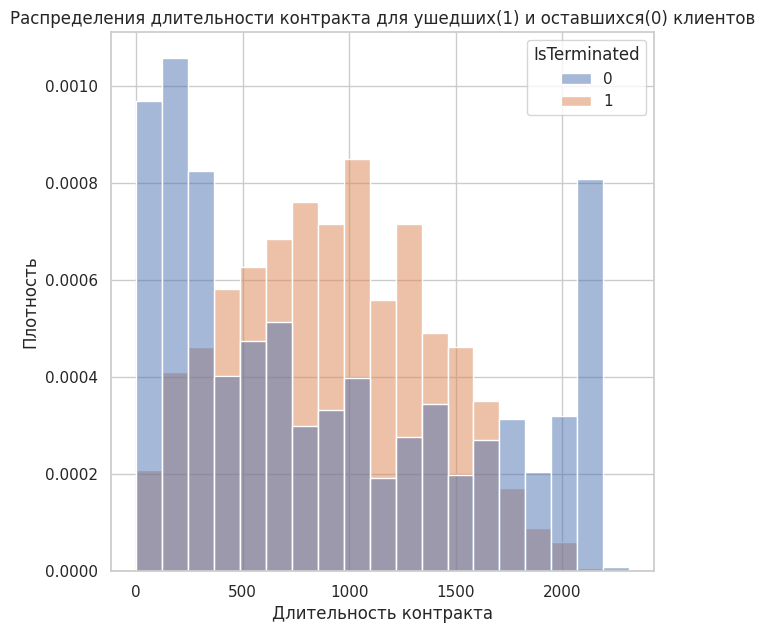

In [68]:
plt.figure(figsize=(7, 7))
sns.histplot(data=df, x="duration", hue="IsTerminated", stat="density", common_norm=False)
plt.xlabel("Длительность контракта")
plt.ylabel("Плотность")
plt.title("Распределения длительности контракта для ушедших(1) и оставшихся(0) клиентов")
plt.show()

**Что можно заметить:**

1. Длительность контракта для ушедших клиентов имеет нормальное распределение с центром около 700-1000 дней (2-3 года), возомжно, бизнесу стоит рассматривать эту цифру как кризисный период клиента, в который максимальную актуальность имеют персональные акции и скидки;

2. Длительность контракта у неушедших клиентов имеет два пика - на минимуме (полгода - год контракта) и на максимуме (5+ лет), что говорит о том, что старые клиенты редко уходят от компании, равно как и новые.

## Выводы

### Шаги проекта

1. Данные выгружены из базы данных;
2. Проведена обработка и стат. анализ данных;
3. Данные объединены, созданы выборки для обучения;
4. Обучены 4 модели:
   1. Линейная регрессия(`val ROC-AUC=0.76`)
   2. Древо решений(`val ROC-AUC=0.78`)
   3. Градиентный бустинг с подбором гиперпараметров(`val ROC-AUC=0.83`)
   4. Нейронная сеть(`val ROC-AUC=0.82`)
5. Проведено тестирование модели градиентного бустинга.

### Результат тестирования

Тестирование лучшей модели показало метрику `ROC-AUC=0.85`

### Рекомендации для бизнеса:

Для прогнозирования ухода клиентов от телефонной компании наиболее критичными являются параметры, связанные с договором и оплатой услуг — длительность сотрудничества, тип оплаты и изменения в расходах. Дополнительные услуги (например, использование нескольких линий связи) также имеют значение, тогда как базовые демографические характеристики практически не влияют на результат модели. Это позволяет компании сосредоточить внимание на улучшении условий контрактов и тарифных планов, чтобы снизить отток клиентов.

Отдельно стоит заметить, что клиенты статистически склонны уходить после 3х лет контракта, возможно, следует рассмотреть эту цифру как момент повышенной актуальности персональных предложений и акций.